In [14]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
batch_size = 10
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

images_path = "/drive0-storage/Gracia/dataset/hc"
with tf.device("CPU"):
    real_images = image_dataset_from_directory(images_path,
                                               image_size = img_size,
                                               batch_size = batch_size,
                                               seed = 123)

    for images, labels in real_images.take(1):
        for i in range(1):
            sample = images[i]
            print(sample.dtype)
            print(np.min(sample), np.max(sample))
            print(sample.shape)

2023-06-05 21:48:04.288617: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 21:48:04.903380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 11900 files belonging to 1 classes.


In [ ]:
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(299,299,3)
    return image

with tf.device("CPU"):
    real_images = (
        real_images
        .shuffle(buffer_size = BUFFER_SIZE)
        .map(preprocess, num_parallel_calls=AUTOTUNE))
    
    images = real_images.take(100)

In [ ]:
# Load the pre-trained InceptionV3 model
with tf.device("CPU"):
    inception_model = InceptionV3(include_top=False,
                                      pooling='avg',
                                      input_shape=(299,299,3))

In [2]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(23*27*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((23, 27, 512)))
    assert model.output_shape == (None, 23, 27, 512) 

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 46, 54, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 92, 108, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 184, 216, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 184, 216, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[184, 216, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

with tf.device("CPU"):
    generator = make_generator_model()
    discriminator = make_discriminator_model()

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<dtype: 'float32'>
0.0 246.46776
(184, 216, 1)


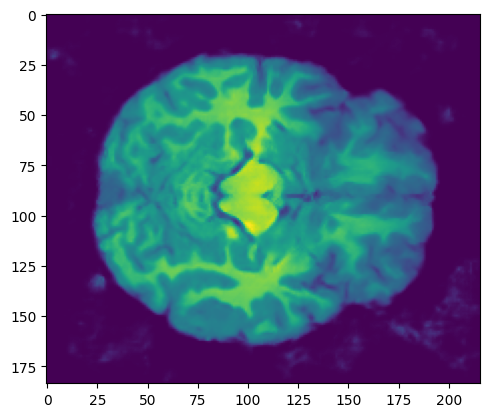

In [23]:
noise_dim = 100
num_examples_to_generate = 10

def preprocess_prediction(image):
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(images, (299,299,3))
    image = image/2 + 0.5
    image *= 255
    return image
    
with tf.device("CPU"):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    predictions = generator(seed, training=False)
#     generated_images = tf.image.grayscale_to_rgb(predictions)
#     generated_images = tf.image.resize(generated_images, (299,299,3))
#     generated_features = inception_model.predict(generated_images)
#     real_features = inception_model.predict(images)

In [ ]:
from scipy.linalg import sqrtm

def calculate_fid_score(real_features, generated_features):
    # Calculate the mean of the real and generated features
    mean_real = np.mean(real_features, axis=0)
    mean_generated = np.mean(generated_features, axis=0)

    # Calculate the covariance matrices of the real and generated features
    cov_real = np.cov(real_features, rowvar=False)
    cov_generated = np.cov(generated_features, rowvar=False)

    # Calculate the squared Euclidean distance between the mean feature vectors
    distance = np.sum((mean_real - mean_generated) ** 2)

    # Calculate the square root of the product of the covariance matrices
    cov_sqrt = sqrtm(cov_real.dot(cov_generated))

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    
    # Calculate the FID score
    fid_score = distance + np.trace(cov_real + cov_generated - 2 * cov_sqrt)

    return fid_score

# Calculate the FID score for the generated and real features
fid_score = calculate_fid_score(real_features, generated_features)
print("FID Score:", fid_score)
